In [8]:
from utils.scraping import scrape_session_html
import pandas as pd
import re
import json 

In [2]:
with open('data/ep_mep_activities.json', 'r') as infile:
    data = json.load(infile)

<Axes: ylabel='Frequency'>

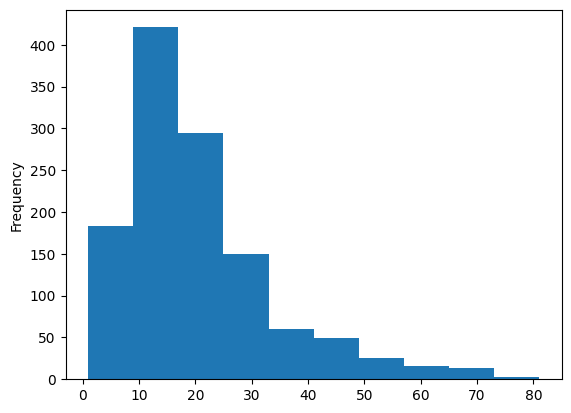

In [3]:
cres = []
for d in data:
    if 'CRE' in d:
        cres.extend(d['CRE'])
cre_df = pd.DataFrame(cres)
term = cre_df[cre_df['term'] == 6]

debate_urls = term[term['title'].str.contains('debate')]['url'].map(lambda x: x.split('&')[0])
debate_urls.value_counts().plot(kind = 'hist')

In [4]:
debate_urls = list(set(debate_urls))
len(debate_urls)

1215

In [5]:
debate_urls

['http://www.europarl.europa.eu/sides/getDoc.do?pubRef=-//EP//TEXT+CRE+20081203+ITEM-019+DOC+XML+V0//EN',
 'http://www.europarl.europa.eu/sides/getDoc.do?pubRef=-//EP//TEXT+CRE+20080116+ITEM-015+DOC+XML+V0//EN',
 'http://www.europarl.europa.eu/sides/getDoc.do?pubRef=-//EP//TEXT+CRE+20061026+ITEM-003+DOC+XML+V0//EN',
 'http://www.europarl.europa.eu/sides/getDoc.do?pubRef=-//EP//TEXT+CRE+20060426+ITEM-015+DOC+XML+V0//EN',
 'http://www.europarl.europa.eu/sides/getDoc.do?pubRef=-//EP//TEXT+CRE+20060314+ITEM-015+DOC+XML+V0//EN',
 'http://www.europarl.europa.eu/sides/getDoc.do?pubRef=-//EP//TEXT+CRE+20060314+ITEM-020+DOC+XML+V0//EN',
 'http://www.europarl.europa.eu/sides/getDoc.do?pubRef=-//EP//TEXT+CRE+20070212+ITEM-014+DOC+XML+V0//EN',
 'http://www.europarl.europa.eu/sides/getDoc.do?pubRef=-//EP//TEXT+CRE+20090310+ITEM-018+DOC+XML+V0//EN',
 'http://www.europarl.europa.eu/sides/getDoc.do?pubRef=-//EP//TEXT+CRE+20060927+ITEM-012+DOC+XML+V0//EN',
 'http://www.europarl.europa.eu/sides/getDoc.d

In [26]:
def get_multilingual_transcript(url):

    
    ml_transcript = {}
    try:
        english_transcripts = scrape_session_html(url)
    except Exception as e:
        print(e)
        return None

    chapter_num = url.split('ITEM-')[1][1:3]
    for english_transcript in english_transcripts:
        if english_transcript['chapter_num'] == chapter_num:
            break

    language_pattern = r"[−–—]\s\((\w{2})\)"
    lang_set = set()
    
    for intervention in english_transcript['interventions']:
        match = re.search(language_pattern, intervention['text'])
        lang = match.group(1) if match else "EN"  # Default to EN if no language code found
        lang_set.add(lang)
        meta = {
            "EN": intervention['text'],
            "speaker": intervention['speaker'],
            "lang": lang
                }
        ml_transcript[intervention['identifier']] = meta
    
    for lang in lang_set:
        lang_url = url.replace('EN', lang)
        lang_transcripts = scrape_session_html(lang_url)
        for lang_transcript in lang_transcripts:
            if lang_transcript['chapter_num'] == chapter_num:
                break
        for intervention in lang_transcript['interventions']:
            if intervention['identifier'] in ml_transcript:
                ml_transcript[intervention['identifier']][lang] = intervention['text']

    
    transcript = {}
    for k,v in ml_transcript.items():
        transcript[k] = {'speaker': v['speaker'], 'english': v['EN'],
         'lang': v['lang'], 'original': v[v['lang']]}

    return transcript

In [27]:
d = get_multilingual_transcript(debate_urls[0])

In [21]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load multilingual model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')



In [ ]:
for intervention_id in d:
    english_text = d[intervention_id]['english']
    original_text = d[intervention_id]['original']
    english_embedding = model.encode(english_text)
    original_embedding = model.encode(original_text)
    similarity = np.dot(english_embedding, original_embedding) / (np.linalg.norm(english_embedding) * np.linalg.norm(original_embedding))
    print(f"{intervention_id}, {similarity}")

3-230, 1.0
3-231, 1.0
3-232, 1.0
3-233, 0.9693926572799683
3-234, 0.9535627961158752
3-235, 0.9570333957672119
3-236, 1.0
3-237, 0.9133411645889282
3-238, 0.9090195298194885
3-239, 0.788557231426239
3-240, 0.9046892523765564
3-241, 0.9999998807907104
3-242, 0.8637094497680664
3-243, 0.9372988343238831
3-244, 1.0
3-245, 0.9089308381080627
3-246, 1.0000001192092896
3-247, 0.9480543732643127
3-248, 1.0000001192092896
3-249, 0.8867088556289673
3-250, 1.0000001192092896
3-251, 0.9999998807907104
3-996, 0.9556763172149658
3-252, 0.9536710381507874
3-253, 0.8968740105628967
3-254, 0.8632639646530151
3-995, 0.9999999403953552
3-255, 0.8896122574806213
3-994, 0.8709380626678467


In [23]:
from utils.bertscore import compute_bertscore_advanced

In [30]:
eng_text_list = []
original_text_list = []
for intervention_id in d:
    english_text = d[intervention_id]['english']
    original_text = d[intervention_id]['original']
    eng_text_list.append(english_text)
    original_text_list.append(original_text)

score = compute_bertscore_advanced(eng_text_list, original_text_list)
list(zip(score['f1'], [d[k]['lang'] for k in d]))

Token indices sequence length is longer than the specified maximum sequence length for this model (895 > 512). Running this sequence through the model will result in indexing errors


[(1.0, 'EN'),
 (1.0, 'EN'),
 (1.0, 'EN'),
 (0.8725989712506832, 'FR'),
 (0.8492351581496591, 'HU'),
 (0.8719667055209481, 'FR'),
 (1.0, 'EN'),
 (0.833191657972141, 'ES'),
 (0.8075647362919737, 'FI'),
 (0.7668437030832347, 'FR'),
 (0.8264011455493395, 'PL'),
 (1.0, 'EN'),
 (0.7738058625107083, 'EL'),
 (0.860250748670862, 'SV'),
 (1.0, 'EN'),
 (0.8648528706855502, 'ES'),
 (1.0, 'EN'),
 (0.8671794282877665, 'RO'),
 (1.0, 'EN'),
 (0.7913680991536888, 'FR'),
 (1.0, 'EN'),
 (0.9999998211860657, 'EN'),
 (0.8793407750691308, 'FR'),
 (0.8629940382235457, 'RO'),
 (0.8313772812110353, 'ET'),
 (0.8087366243807789, 'PL'),
 (1.0, 'EN'),
 (0.8287790892414678, 'CS'),
 (0.8039372609143661, 'SK')]

In [33]:
eng_text_list[1]

'Gay Mitchell, rapporteur . − Mr President, the food facility began as a proposal from the Commission, in the light of the rising food prices that provoked riots in some countries, to use EUR\xa01\xa0billion in leftover agricultural subsidy money to relieve the situation in developing countries through agricultural inputs and emergency safety nets. The money was, in this form, expected to be wholly additional to existing development funds. Now, five months later, we have our billion, but it is in an entirely different form than that originally envisaged.\nTwo Fridays ago, I attended the budget conciliation meeting, with my colleagues from the Committee on Budgets and the Council, where we were finally able to reach a compromise over the funding of the food facility regulation. The last sticking points were then ironed out on the following Monday at a trialogue between Parliament, Commission and Council.\nThe final compromise funding looks like this: EUR\xa01\xa0billion to be financed o

In [11]:

ml_transcript = {}
try:
    english_transcripts = scrape_session_html(url)
except Exception as e:
    print(e)


In [14]:
english_transcripts

In [ ]:

chapter_num = url.split('ITEM-')[1][1:3]
for english_transcript in english_transcripts:
    if english_transcript['chapter_num'] == chapter_num:
        break

language_pattern = r"[−–—]\s\((\w{2})\)"
lang_set = set()

for intervention in english_transcript['interventions']:
    match = re.search(language_pattern, intervention['text'])
    lang = match.group(1) if match else "EN"  # Default to EN if no language code found
    lang_set.add(lang)
    meta = {
        "EN": intervention['text'],
        "speaker": intervention['speaker'],
        "lang": lang
            }
    ml_transcript[intervention['identifier']] = meta

for lang in lang_set:
    lang_url = url.replace('EN', lang)
    lang_transcripts = scrape_session_html(lang_url)
    for lang_transcript in lang_transcripts:
        if lang_transcript['chapter_num'] == chapter_num:
            break
    for intervention in lang_transcript['interventions']:
        if intervention['identifier'] in ml_transcript:
            ml_transcript[intervention['identifier']][lang] = intervention['text']
